In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import matplotlib.patches as mpatches

# Merge excel files
path = "datasets/output/data_cleaned.xlsx"

dataset_df = pd.read_excel(path)

In [2]:
dataset_df = dataset_df[['CCAN', 'DATE', 'Status', 'TOT NET', 'Net Investment', '31-60', '61-90', '91-120', '120+', 'Past Due', 'Aging', 'Country']]

dataset_df.count()

CCAN              140236
DATE              140236
Status            140236
TOT NET           140236
Net Investment    140236
31-60             140236
61-90             140236
91-120            140236
120+              140236
Past Due          140236
Aging             140236
Country           140236
dtype: int64

In [3]:
# Count number of months as input
input_files = os.listdir("datasets/input/")
input_count = len(input_files)

# Create average per month past due and in millions per month
extended_dataset_df = dataset_df
extended_dataset_df["Past Due AVG MLN"] = round(extended_dataset_df["Past Due"] / input_count / 1000000, 2)
extended_dataset_df["Net Investment AVG MLN"] = round(extended_dataset_df["Net Investment"] / input_count / 1000000, 2)
extended_dataset_df["Year"] = pd.DatetimeIndex(extended_dataset_df['DATE']).year
extended_dataset_df["Past Due MLN"] = round(extended_dataset_df["Past Due"] / 1000000, 2)
extended_dataset_df["TOT NET MLN"] = round(extended_dataset_df["TOT NET"] / 1000000, 2)
extended_dataset_df["Net Investment AVG YEAR MLN"] = round(extended_dataset_df["Net Investment"] / 12 / 1000000, 2)
extended_dataset_df["Net Investment MLN"] = round(extended_dataset_df["Net Investment"] / 1000000, 2)

extended_dataset_df.head()

,CCAN,DATE,Status,TOT NET,Net Investment,31-60,61-90,91-120,120+,Past Due,Aging,Country,Past Due AVG MLN,Net Investment AVG MLN,Year,Past Due MLN,TOT NET MLN,Net Investment AVG YEAR MLN,Net Investment MLN
0,320023,2016-01-31,LEGAL,1.534098e+09,15555962.86,0.00,0.00,0.00,15555962.86,15555962.86,120+,MEXICO,0.20,0.20,2016,15.56,1534.1,1.30,15.56
1,315112,2016-01-31,LEGAL,1.534098e+09,3265682.10,0.00,0.00,0.00,3265682.10,3265682.10,120+,MEXICO,0.04,0.04,2016,3.27,1534.1,0.27,3.27
2,309348,2016-01-31,REGULAR,1.534098e+09,3006305.90,0.00,356160.13,1678580.73,971565.04,3006305.90,120+,COSTA RICA,0.04,0.04,2016,3.01,1534.1,0.25,3.01
3,320248,2016-01-31,REGULAR,1.534098e+09,2874745.56,0.00,1191181.78,1683563.78,0.00,2874745.56,91-120,MEXICO,0.04,0.04,2016,2.87,1534.1,0.24,2.87
4,308247,2016-01-31,REGULAR,1.534098e+09,2556572.66,729813.89,0.00,1826758.77,0.00,2556572.66,91-120,GUATEMALA,0.03,0.03,2016,2.56,1534.1,0.21,2.56


In [4]:
# Get dataset only Legal Customers
ext_dat_LEGAL_df = extended_dataset_df.loc[(extended_dataset_df["Status"] == 'LEGAL')&(extended_dataset_df["Country"]!='VENEZUELA')].dropna()
# Calculate average Past Due in million USD per month per country
country_count_legal = ext_dat_LEGAL_df.groupby(["Country","CCAN"])["Net Investment"].mean()
prueba=pd.DataFrame(country_count_legal)
prueba.reset_index(inplace=True)
prueba

,Country,CCAN,Net Investment
0,BELICE,308932,1.233804e+04
1,COLOMBIA,18645,9.454767e+04
2,COLOMBIA,18647,3.100079e+04
3,COLOMBIA,18758,1.048620e+04
4,COLOMBIA,18792,1.734914e+04
...,...,...,...
1170,REPUBLICA DOMINICANA,316137,5.948492e+04
1171,REPUBLICA DOMINICANA,316300,9.571780e+04
1172,REPUBLICA DOMINICANA,316978,1.847610e+06
1173,REPUBLICA DOMINICANA,320022,2.406551e+06


In [5]:
#Calculate the quartiles and IQR and quantitatively determine if there are any potential outliers
#across all four treatment regimens.

#Put treatments into a list for for loop (and later for plot labels)

list_1=prueba['Country'].unique()
country_list=list_1.tolist()



print(' Legal by Country:')
print('------------------------------')

for country in country_list:
    print(f'Country: {country}')
    pais = prueba[prueba['Country'] == country]
    quartiles = pais['Net Investment'].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f"The lower quartile of Net Investment for {country} is: {lowerq}")
    print(f"The upper quartile of Net Investment for {country}is: {upperq}")
    print(f"The interquartile range of Net Investment for {country} is: {iqr}")
    print(f"The the median of Net Investment for {country}is: {quartiles[0.5]} ")
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"Maximum Value {prueba[prueba['Country'] == country]['Net Investment'].max()}")
    print(f"Min Value {prueba[prueba['Country'] == country]['Net Investment'].min()}")
    if upper_bound > prueba[prueba['Country'] == country]['Net Investment'].max():
        print("Since Maximun value is less than upper bound, there are no outliers in the upper level")
    else:
        print("Since Maximun value is higher than upper bound, there are possible outliers in the upper level")
    if lower_bound < prueba[prueba['Country'] == country]['Net Investment'].min():
        print("Since Minimum value is higher than lower bound, there are no outliers in the lower level")
    else:
        print("Since Minimun value is less than lower bound, there are possible outliers in the lower level")
    
    print('*********************************')
    
# Locate the rows which contain mice on each drug and get the tumor volumes  
# add subset 
# Determine outliers using upper and lower bounds
    

 Legal by Country:
------------------------------
Country: BELICE
The lower quartile of Net Investment for BELICE is: 12338.04
The upper quartile of Net Investment for BELICEis: 12338.04
The interquartile range of Net Investment for BELICE is: 0.0
The the median of Net Investment for BELICEis: 12338.04 
Values below 12338.04 could be outliers.
Values above 12338.04 could be outliers.
Maximum Value 12338.04
Min Value 12338.04
Since Maximun value is higher than upper bound, there are possible outliers in the upper level
Since Minimun value is less than lower bound, there are possible outliers in the lower level
*********************************
Country: COLOMBIA
The lower quartile of Net Investment for COLOMBIA is: 15853.853687796824
The upper quartile of Net Investment for COLOMBIAis: 95446.56413256787
The interquartile range of Net Investment for COLOMBIA is: 79592.71044477104
The the median of Net Investment for COLOMBIAis: 37797.77078788585 
Values below -103535.21197935974 could be 

In [13]:
prueba = prueba.loc[(prueba["Country"]!='ST VINCENT')].dropna()

prueba["Net Investment MLN"] = round(prueba["Net Investment"] / 1000, 2)
prueba

,Country,CCAN,Net Investment,Net Investment MLN
0,BELICE,308932,1.233804e+04,12.34
1,COLOMBIA,18645,9.454767e+04,94.55
2,COLOMBIA,18647,3.100079e+04,31.00
3,COLOMBIA,18758,1.048620e+04,10.49
4,COLOMBIA,18792,1.734914e+04,17.35
...,...,...,...,...
1169,REPUBLICA DOMINICANA,1319474,2.704125e+05,270.41
1170,REPUBLICA DOMINICANA,316137,5.948492e+04,59.48
1171,REPUBLICA DOMINICANA,316300,9.571780e+04,95.72
1172,REPUBLICA DOMINICANA,316978,1.847610e+06,1847.61


<Figure size 21600x720 with 0 Axes>

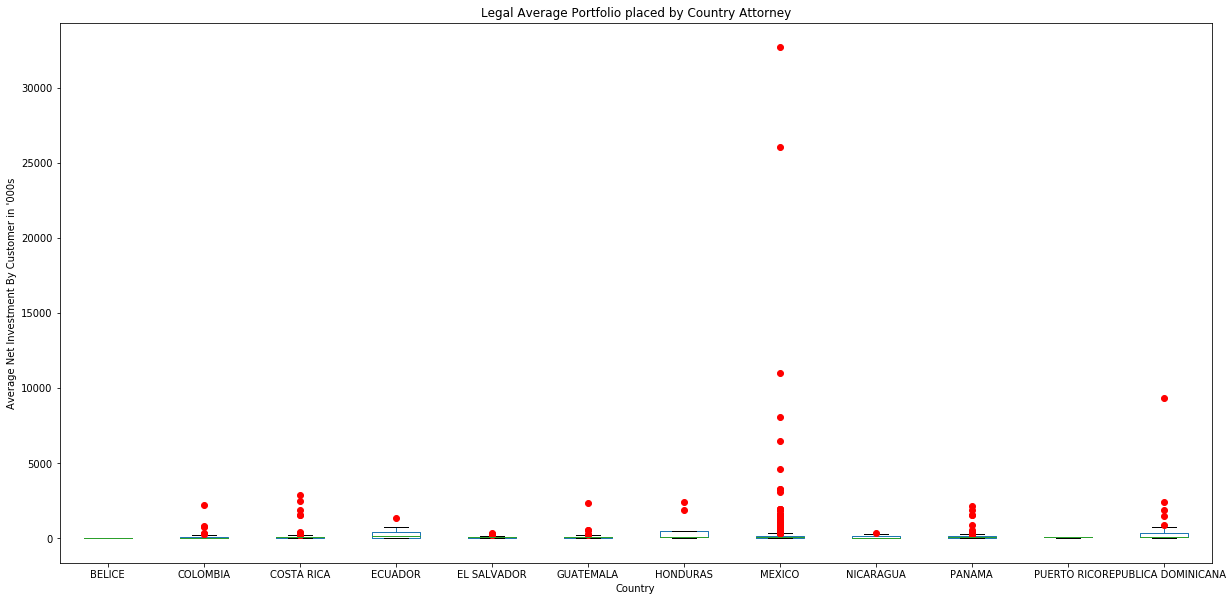

In [16]:
plt.figure(figsize=(300,10))

prueba.boxplot(by='Country', column=["Net Investment MLN"], grid=False, showfliers=True, sym='r',figsize=(20,10))
plt.ylabel("Average Net Investment By Customer in '000s")
plt.title('Legal Average Portfolio placed by Country Attorney')
plt.suptitle(None)

plt.show()

In [19]:

prueba = prueba.drop(prueba[prueba["Net Investment MLN"]>2000].index)
prueba

,Country,CCAN,Net Investment,Net Investment MLN
0,BELICE,308932,1.233804e+04,12.34
1,COLOMBIA,18645,9.454767e+04,94.55
2,COLOMBIA,18647,3.100079e+04,31.00
3,COLOMBIA,18758,1.048620e+04,10.49
4,COLOMBIA,18792,1.734914e+04,17.35
...,...,...,...,...
1168,REPUBLICA DOMINICANA,1037336,7.127391e+04,71.27
1169,REPUBLICA DOMINICANA,1319474,2.704125e+05,270.41
1170,REPUBLICA DOMINICANA,316137,5.948492e+04,59.48
1171,REPUBLICA DOMINICANA,316300,9.571780e+04,95.72


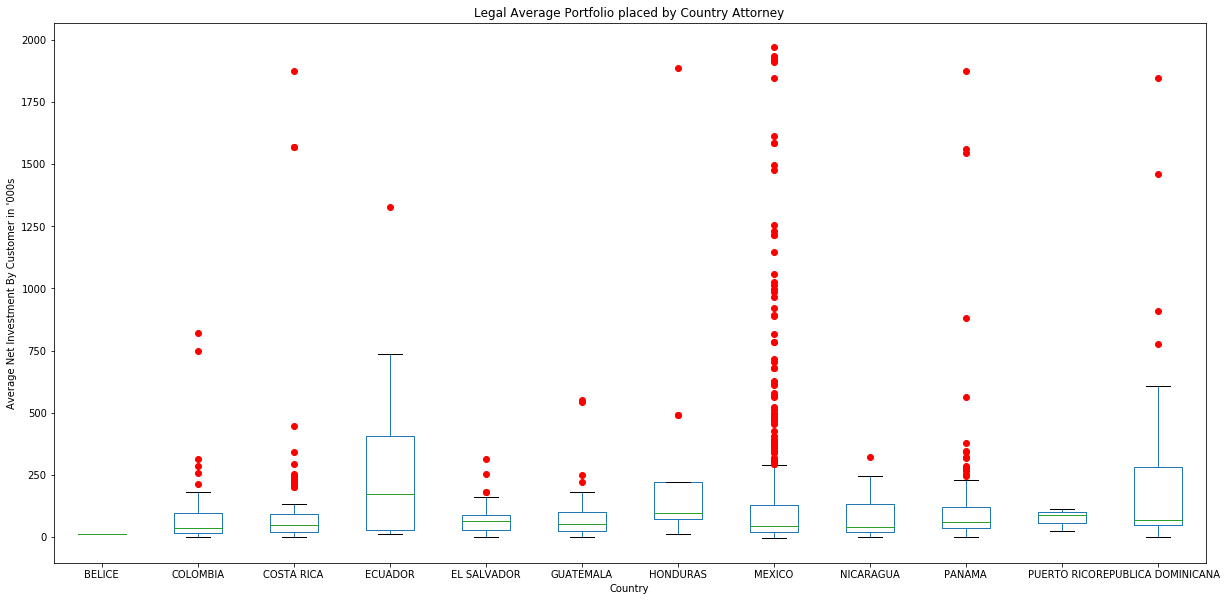

In [21]:
#plt.figure(figsize=(300,10))

prueba.boxplot(by='Country', column=["Net Investment MLN"], grid=False, showfliers=True, sym='r',figsize=(20,10))
plt.ylabel("Average Net Investment By Customer in '000s")
plt.title('Legal Average Portfolio placed by Country Attorney')
plt.suptitle(None)

plt.show()

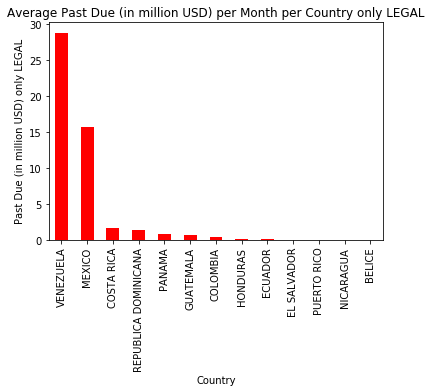

In [15]:
# Get dataset only Legal Customers
ext_dat_LEGAL_df = extended_dataset_df.loc[(extended_dataset_df["Status"] == 'LEGAL')&(extended_dataset_df["Aging"]!='1-30')].dropna()
# Calculate average Past Due in million USD per month per country
country_count_legal = ext_dat_LEGAL_df.groupby(["Country"])["Past Due AVG MLN"].sum()

# Plot bar graph
country_count_legal = country_count_legal.sort_values(ascending=False)
country_count_legal.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD) only LEGAL")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country only LEGAL")
plt.show()

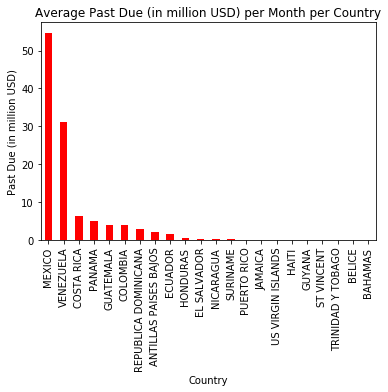

In [19]:
# Calculate average Past Due in million USD per month per country
country_count = extended_dataset_df.groupby(["Country"])["Past Due AVG MLN"].sum()

# Plot bar graph
country_count = country_count.sort_values(ascending=False)
country_count.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country")
plt.show()

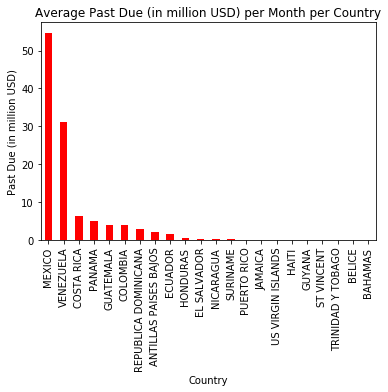

In [20]:
# Calculate average Past Due in million USD per month per country
country_count = extended_dataset_df.groupby(["Country"])["Past Due AVG MLN"].sum()

# Plot bar graph
country_count = country_count.sort_values(ascending=False)
country_count.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country")
plt.show()

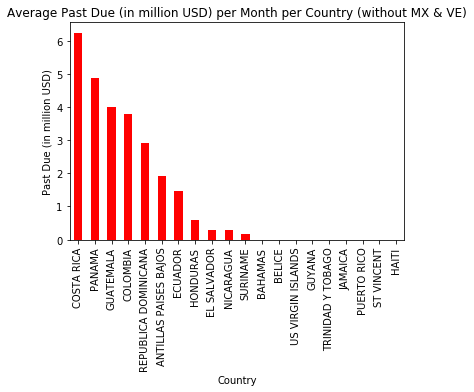

In [6]:
# Get dataset without Mexico and Venezuela
ext_dat_nomx_df = extended_dataset_df.loc[(extended_dataset_df["Country"] != 'MEXICO')].dropna()
ext_dat_nomx_df = ext_dat_nomx_df.loc[(ext_dat_nomx_df["Country"] != 'VENEZUELA')].dropna()

# Calculate average Past Due in USD per month per country
country_count2 = ext_dat_nomx_df.groupby(["Country"])["Past Due AVG MLN"].sum()
country_count2 = country_count2.sort_values(ascending=False)
country_count2.plot(kind="bar", facecolor="red")

plt.ylabel("Past Due (in million USD)")
plt.xlabel("Country")
plt.title("Average Past Due (in million USD) per Month per Country (without MX & VE)")
plt.show()                                        
                                          

In [21]:
def year_overview(yearyear):
    year_df = extended_dataset_df.loc[(extended_dataset_df["Year"] == yearyear)].dropna()
    # Group by customer
    customer_gbdf = year_df.groupby(['CCAN'])
    #customer_gbdf = extended_dataset_df.groupby(['CCAN'])

    #customer_gbdf = customer_gbdf[['CCAN', 'Net Investment AVG MLN']]

    # Past Due Count
    cust_pd_count = customer_gbdf['Net Investment AVG YEAR MLN'].sum()
    cust_country = customer_gbdf['Country'].unique().str[0]

    #summary table
    sum_cust_pd_df = pd.DataFrame({
            "Net Investment AVG MLN":cust_pd_count,
            "Country":cust_country})
    sum_cust_pd_df.index.name="CCAN"

    sum_cust_pd_df = sum_cust_pd_df.reset_index()
    # Filter top four countries out of DF
    sum_cust_pd_df = sum_cust_pd_df.loc[((sum_cust_pd_df["Country"] == 'MEXICO') | (sum_cust_pd_df["Country"] == 'VENEZUELA')
                                         | (sum_cust_pd_df["Country"] == 'COSTA RICA') | (sum_cust_pd_df["Country"] == 'PANAMA')
                                        )].dropna()


    # get dataframe sorted by life Expectancy in each continent 
    top_net_inv = sum_cust_pd_df.groupby(["Country"]).apply(lambda x: x.sort_values(["Net Investment AVG MLN"], ascending = False)).reset_index(drop=True)
    # select top N rows within each continent
    n_clients = 2
    top_net_inv = top_net_inv.groupby('Country').head(n_clients)
    #number = year
    
    objects = top_net_inv['CCAN']
    x_value = np.arange(len(objects))
    performance = top_net_inv['Net Investment AVG MLN']

    # plot bar
    plt.bar(x_value, performance, align='center', color=('#FFC30F', '#FFC30F', '#FF5733', '#FF5733', 
                                                         '#c70039', '#c70039', '#581845', '#581845'))
    plt.xticks(x_value, objects)

    col1 = mpatches.Patch(color='#FFC30F', label='Costa Rica')
    col2 = mpatches.Patch(color='#FF5733', label='Mexico')
    col3 = mpatches.Patch(color='#c70039', label='Panama')
    col4 = mpatches.Patch(color='#581845', label='Venezuela')

    plt.legend(handles=[col1, col2, col3, col4])
    plt.xlabel('CCAN')
    plt.ylabel('Net Investment per month (in million USD)')
    plt.title('Top 2 clients in Net Inv Avg (mln USD) per top 4 country in ' + str(yearyear))

    return plt.show(), print(top_net_inv)
    

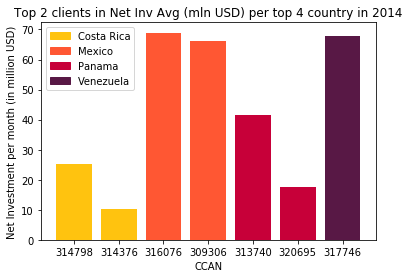

        CCAN  Net Investment AVG MLN     Country
0     314798                   25.11  COSTA RICA
1     314376                   10.09  COSTA RICA
176   316076                   68.93      MEXICO
177   309306                   66.31      MEXICO
1292  313740                   41.51      PANAMA
1293  320695                   17.57      PANAMA
1463  317746                   67.91   VENEZUELA


(None, None)

In [27]:
year_overview(2014)


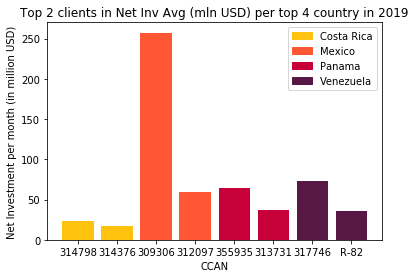

        CCAN  Net Investment AVG MLN     Country
0     314798                   23.86  COSTA RICA
1     314376                   17.54  COSTA RICA
260   309306                  257.28      MEXICO
261   312097                   58.77      MEXICO
1283  355935                   64.65      PANAMA
1284  313731                   37.08      PANAMA
1558  317746                   73.32   VENEZUELA
1559    R-82                   35.73   VENEZUELA


(None, None)

In [8]:
year_overview(2019)

In [28]:
path1 = "datasets/output/exchange_rates.csv"
exchange_rates_df = pd.read_csv(path1)
exchange_rates_df

,Unnamed: 0,Date,Exhange Rate
0,0,2012-01-31,12.980045
1,1,2012-02-28,12.840447
2,2,2012-03-31,12.710813
3,3,2012-04-30,12.993272
4,4,2012-05-31,14.241763
...,...,...,...
99,99,2020-04-30,24.230800
100,100,2020-05-31,22.185207
101,101,2020-06-30,23.019400
102,102,2020-07-31,22.283049


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30          212.32    1475.27      14.391942
2014-05-31           74.57    1586.63       4.699899
2014-06-30           94.45    1525.45       6.191616
2014-07-31           86.18    1597.91       5.393295
2014-08-31          105.76    1535.10       6.889453
...                    ...        ...            ...
2020-03-31          144.86    1144.26      12.659710
2020-04-30          148.14    1136.23      13.037853
2020-05-31          163.84    1159.34      14.132179
2020-06-30          158.56    1183.65      13.395852
2020-07-31          150.98    1166.09      12.947543

[76 rows x 3 columns]


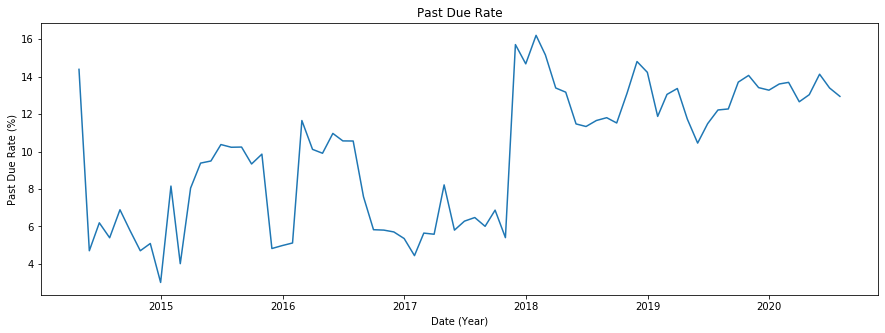

In [29]:
new_extended_dataset_df = extended_dataset_df.groupby(['DATE'])
#print(new_extended_dataset_df)
sum_past_due = new_extended_dataset_df['Past Due MLN'].sum()
total_net = new_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index = pd.DataFrame({
    "Total Past Due": sum_past_due,
    "Total Net": total_net,
    "Past Due Rate": (sum_past_due / total_net) * 100
    
})
print(past_due_index)

fig = plt.figure(figsize=(15,5))

y = past_due_index['Past Due Rate']
x = past_due_index.index
plt.title('Past Due Rate')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30          156.46    1475.27      10.605516
2014-05-31           41.35    1586.63       2.606153
2014-06-30           67.29    1525.45       4.411157
2014-07-31           41.83    1597.91       2.617794
2014-08-31           53.35    1535.10       3.475344
...                    ...        ...            ...
2020-03-31           34.29    1144.26       2.996697
2020-04-30           31.93    1136.23       2.810170
2020-05-31           37.25    1159.34       3.213035
2020-06-30           33.37    1183.65       2.819246
2020-07-31           29.85    1166.09       2.559837

[76 rows x 3 columns]


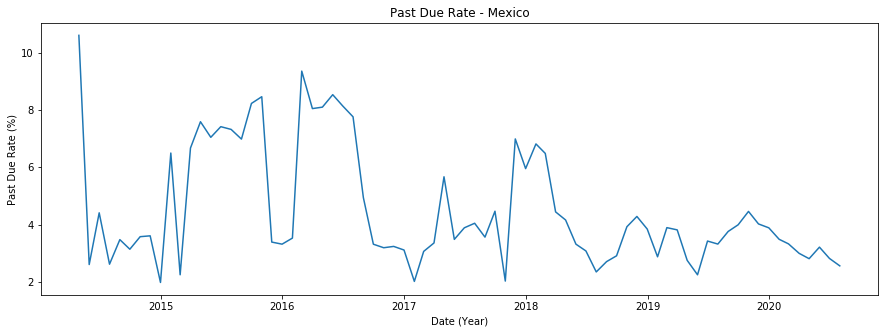

In [30]:
mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'MEXICO')]
mexico_extended_dataset_df = mexico_df.groupby(['DATE'])

#print(new_extended_dataset_df)
sum_past_due_mx = mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = mexico_extended_dataset_df['TOT NET MLN'].unique().str[0]
past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100
    
})
print(past_due_index_mx )

fig = plt.figure(figsize=(15,5))

y = past_due_index_mx['Past Due Rate']
x = past_due_index_mx.index
plt.title('Past Due Rate - Mexico')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)
plt.show()

            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30           55.86    1475.27       3.786426
2014-05-31           33.22    1586.63       2.093746
2014-06-30           27.16    1525.45       1.780458
2014-07-31           44.35    1597.91       2.775500
2014-08-31           52.41    1535.10       3.414110
...                    ...        ...            ...
2020-03-31          110.57    1144.26       9.663014
2020-04-30          116.21    1136.23      10.227683
2020-05-31          126.59    1159.34      10.919144
2020-06-30          125.19    1183.65      10.576606
2020-07-31          121.13    1166.09      10.387706

[76 rows x 3 columns]


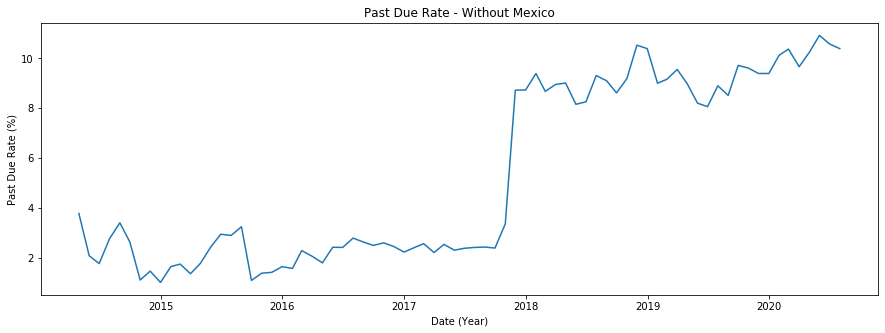

In [41]:
without_mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] != 'MEXICO')]
without_mexico_extended_dataset_df = without_mexico_df.groupby(['DATE'])

#print(new_extended_dataset_df)
sum_past_due_mx = without_mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = without_mexico_extended_dataset_df['TOT NET MLN'].unique().str[0]
without_mex_past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100
    
})
print(without_mex_past_due_index_mx)

fig = plt.figure(figsize=(15,5))

y = without_mex_past_due_index_mx['Past Due Rate']
x = without_mex_past_due_index_mx.index
plt.title('Past Due Rate - Without Mexico')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)
plt.show()

### Past Due Rate vs. USD to MXN Exchange Rate

In [31]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_df = past_due_index
exc_pastdue_df.reset_index(level=0, inplace=True)
exc_pastdue_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_df['Date'] = exc_pastdue_df['Date'].astype(str)
exc_pastdue_df['Date'] = exc_pastdue_df['Date'].str[:-3]

exc_pastdue_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,212.32,1475.27,14.391942
1,2014-05,74.57,1586.63,4.699899
2,2014-06,94.45,1525.45,6.191616
3,2014-07,86.18,1597.91,5.393295
4,2014-08,105.76,1535.10,6.889453


In [32]:
# Getting Exchange Rate data
exchange_rate_path = "datasets/output/exchange_rates.csv"
exchange_rate_df = pd.read_csv(exchange_rate_path)
del exchange_rate_df['Unnamed: 0']
exchange_rate_df['Date'] = exchange_rate_df['Date'].str[:-3]
exchange_rate_df.head()

,Date,Exhange Rate
0,2012-01,12.980045
1,2012-02,12.840447
2,2012-03,12.710813
3,2012-04,12.993272
4,2012-05,14.241763


In [33]:
# Merge both DataFrames
exc_pastdue_df = exc_pastdue_df.merge(exchange_rate_df)
exc_pastdue_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,Exhange Rate
0,2014-04,212.32,1475.27,14.391942,13.08806
1,2014-05,74.57,1586.63,4.699899,12.85641
2,2014-06,94.45,1525.45,6.191616,12.97124
3,2014-07,86.18,1597.91,5.393295,13.19951
4,2014-08,105.76,1535.10,6.889453,13.07460


The correlation between both factors is 0.46
The r-squared is: 0.21536568886207355


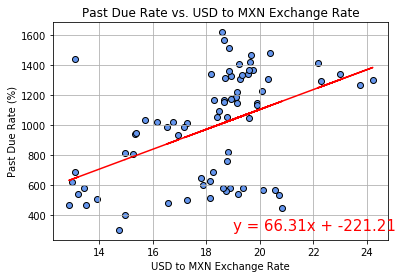

In [37]:
# Scatter plot
x_values = exc_pastdue_df['Exhange Rate']
y_values = exc_pastdue_df['Past Due Rate'] * 100
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

### Past Due Rate vs. USD to MXN Exchange Rate without Mexico

In [42]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_wo_mx_df = without_mex_past_due_index_mx
exc_pastdue_wo_mx_df.reset_index(level=0, inplace=True)
exc_pastdue_wo_mx_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_wo_mx_df['Date'] = exc_pastdue_wo_mx_df['Date'].astype(str)
exc_pastdue_wo_mx_df['Date'] = exc_pastdue_wo_mx_df['Date'].str[:-3]

exc_pastdue_wo_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate
0,2014-04,55.86,1475.27,3.786426
1,2014-05,33.22,1586.63,2.093746
2,2014-06,27.16,1525.45,1.780458
3,2014-07,44.35,1597.91,2.775500
4,2014-08,52.41,1535.10,3.414110


In [43]:
# Merge both DataFrames
exc_pastdue_wo_df = exc_pastdue_wo_mx_df.merge(exchange_rate_df)
exc_pastdue_wo_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,Exhange Rate
0,2014-04,55.86,1475.27,3.786426,13.08806
1,2014-05,33.22,1586.63,2.093746,12.85641
2,2014-06,27.16,1525.45,1.780458,12.97124
3,2014-07,44.35,1597.91,2.775500,13.19951
4,2014-08,52.41,1535.10,3.414110,13.07460


The correlation between both factors is 0.63
The r-squared is: 0.393179293066853


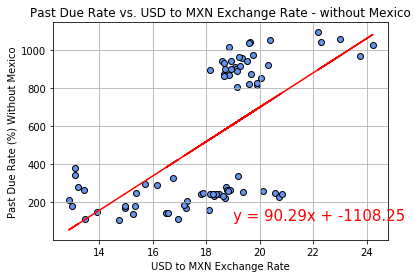

In [45]:
# Scatter plot
x_values = exc_pastdue_wo_df['Exhange Rate']
y_values = exc_pastdue_wo_df['Past Due Rate'] * 100
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate - without Mexico')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%) Without Mexico')
plt.grid()
plt.show()

## Past Due Rate vs. USD to MXN Exchange Rate Mexico


In [39]:
# Merge both DataFrames
exc_pastdue_mx_df = exc_pastdue_mx_df.merge(exchange_rate_df)
exc_pastdue_mx_df.head()

,Date,Total Past Due,Total Net,Past Due Rate,Exhange Rate
0,2014-04,156.46,1475.27,10.605516,13.08806
1,2014-05,41.35,1586.63,2.606153,12.85641
2,2014-06,67.29,1525.45,4.411157,12.97124
3,2014-07,41.83,1597.91,2.617794,13.19951
4,2014-08,53.35,1535.10,3.475344,13.07460


The correlation between both factors is -0.29
The r-squared is: 0.08406676559808879


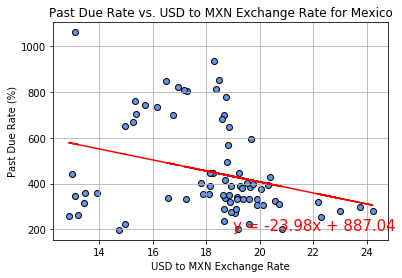

In [40]:
# Scatter plot
x_values = exc_pastdue_mx_df['Exhange Rate']
y_values = exc_pastdue_mx_df['Past Due Rate'] * 100
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between both factors is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(f"The r-squared is: {rvalue**2}")
plt.scatter(x_values,y_values, color='cornflowerblue', edgecolors='black')
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (19, min(y_values)), fontsize=15, color="red")
plt.title('Past Due Rate vs. USD to MXN Exchange Rate for Mexico')
plt.xlabel('USD to MXN Exchange Rate')
plt.ylabel('Past Due Rate (%)')
plt.grid()
plt.show()

In [ ]:
# Creating new column in DataFrame to include the USD to MEX Exchange Rate
exc_pastdue_mx_df = past_due_index_mx
exc_pastdue_mx_df.reset_index(level=0, inplace=True)
exc_pastdue_mx_df.rename(columns = {'DATE':'Date'}, inplace = True)
exc_pastdue_mx_df['Date'] = exc_pastdue_mx_df['Date'].astype(str)
exc_pastdue_mx_df['Date'] = exc_pastdue_mx_df['Date'].str[:-3]

exc_pastdue_mx_df.head()

In [60]:
past_due_index_mx

,Total Past Due,Total Net,Past Due Rate
DATE,,,
2014-04-30,156.46,949.58,16.476758
2014-05-31,41.35,954.23,4.333337
2014-06-30,67.29,854.41,7.875610
2014-07-31,41.83,947.34,4.415521
2014-08-31,53.35,947.72,5.629300
...,...,...,...
2020-03-31,34.29,558.04,6.144721
2020-04-30,31.93,556.22,5.740534
2020-05-31,37.25,561.60,6.632835


                      President               Country Term Start  \
0            Enrique Peña Nieto                Mexico 2012-12-01   
1   Andres Manuel Lopez Obrador                Mexico 2018-12-01   
2            Juan Manuel Santos              Colombia 2010-08-07   
3            Ivan Duque Marquez              Colombia 2018-08-07   
4              Laura Chinchilla            Costa Rica 2010-05-08   
5          Luis Guillermo Solis            Costa Rica 2014-05-08   
6       Carlos Alvarado Quesada            Costa Rica 2018-05-08   
7                 Rafael Correa               Ecuador 2007-01-15   
8                  Lenin Moreno               Ecuador 2017-05-24   
9            Juan Carlos Varela                Panama 2014-07-01   
10           Laurentino Cortizo                Panama 2019-07-01   
11                Danilo Medina  Republica Dominicana 2012-08-16   
12                Luis Abinader  Republica Dominicana 2020-08-16   
13            Otto Perez Molina             Guat

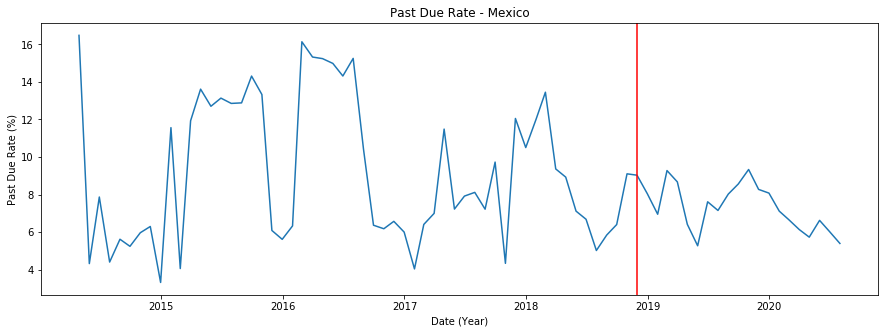

In [57]:
import datetime as dt
# Getting Exchange Rate data
presidents_path = "datasets/presidents.xlsx"
presidents_df_1 = pd.read_excel(presidents_path)
print(presidents_df_1 )


mexico_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'MEXICO')]
mexico_extended_dataset_df = mexico_df.groupby(['DATE'])
#print(new_extended_dataset_df)
sum_past_due_mx = mexico_extended_dataset_df['Past Due MLN'].sum()
total_net_mx = mexico_extended_dataset_df["Net Investment MLN"].sum()
past_due_index_mx = pd.DataFrame({
    "Total Past Due": sum_past_due_mx,
    "Total Net": total_net_mx,
    "Past Due Rate": (sum_past_due_mx / total_net_mx) * 100
    
})
print(past_due_index_mx )
fig = plt.figure(figsize=(15,5))
y = past_due_index_mx['Past Due Rate']
x = past_due_index_mx.index
plt.title('Past Due Rate - Mexico')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)


plt.axvline(dt.datetime(2018, 12, 1), color='red')
#plt.show()


            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30           45.27     191.05      23.695368
2014-05-31           14.06     190.35       7.386393
2014-06-30           14.58     195.42       7.460854
2014-07-31           14.94     184.04       8.117800
2014-08-31            8.13     181.68       4.474901
...                    ...        ...            ...
2020-03-31            6.72     121.05       5.551425
2020-04-30            6.72     126.25       5.322772
2020-05-31            5.98     126.24       4.737009
2020-06-30            4.92     126.16       3.899810
2020-07-31            4.79     127.59       3.754213

[76 rows x 3 columns]


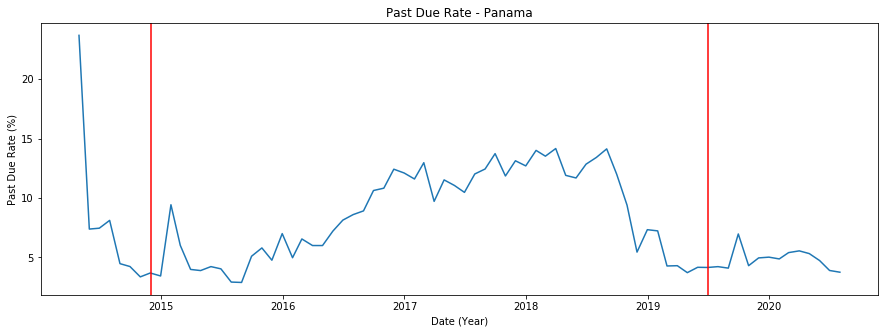

In [59]:
panama_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'PANAMA')]
panama_extended_dataset_df = panama_df.groupby(['DATE'])
#print(new_extended_dataset_df)
sum_past_due_pa = panama_extended_dataset_df['Past Due MLN'].sum()
total_net_pa = panama_extended_dataset_df["Net Investment MLN"].sum()
past_due_index_pa = pd.DataFrame({
    "Total Past Due": sum_past_due_pa,
    "Total Net": total_net_pa,
    "Past Due Rate": (sum_past_due_pa / total_net_pa) * 100
    
})
print(past_due_index_pa)

fig = plt.figure(figsize=(15,5))

y = past_due_index_pa['Past Due Rate']
x = past_due_index_pa.index
plt.title('Past Due Rate - Panama')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)
plt.axvline(dt.datetime(2014, 12, 1), color='red')
plt.axvline(dt.datetime(2019, 7, 1), color='red')
#plt.show()

            Total Past Due  Total Net  Past Due Rate
DATE                                                
2014-04-30            3.55      85.07       4.173034
2014-05-31            2.95      88.47       3.334464
2014-06-30            1.95      92.50       2.108108
2014-07-31            2.56      98.03       2.611445
2014-08-31            1.46      80.77       1.807602
...                    ...        ...            ...
2020-03-31            4.54      73.23       6.199645
2020-04-30           10.85      81.15      13.370302
2020-05-31           16.95      82.70      20.495768
2020-06-30           21.71      85.69      25.335512
2020-07-31           21.24      84.62      25.100449

[76 rows x 3 columns]


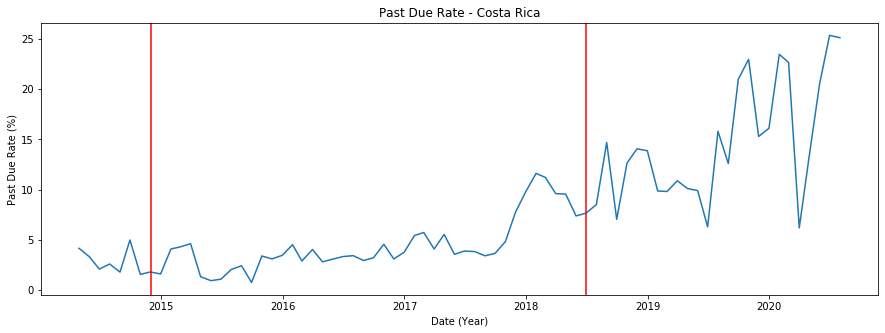

In [61]:
cr_df = extended_dataset_df.loc[(extended_dataset_df["Country"] == 'COSTA RICA')]
cr_extended_dataset_df = cr_df.groupby(['DATE'])
#print(new_extended_dataset_df)
sum_past_due_cr = cr_extended_dataset_df['Past Due MLN'].sum()
total_net_cr = cr_extended_dataset_df["Net Investment MLN"].sum()
past_due_index_cr = pd.DataFrame({
    "Total Past Due": sum_past_due_cr,
    "Total Net": total_net_cr,
    "Past Due Rate": (sum_past_due_cr / total_net_cr) * 100
    
})
print(past_due_index_cr)

fig = plt.figure(figsize=(15,5))

y = past_due_index_cr['Past Due Rate']
x = past_due_index_cr.index
plt.title('Past Due Rate - Costa Rica')
plt.xlabel('Date (Year)')
plt.ylabel('Past Due Rate (%)')
plt.plot(x,y)
plt.axvline(dt.datetime(2014, 12, 1), color='red')
plt.axvline(dt.datetime(2018, 7, 1), color='red')
#plt.show()